In [222]:
## Importing Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, AncillaRegister, Aer, execute, assemble
from qiskit_aer import AerSimulator
from qiskit.circuit import Gate
from qiskit.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
from qiskit.quantum_info import Operator
from qiskit.circuit.library import MCMT, RYGate, RXGate, PhaseGate
import numpy as np
np.set_printoptions(threshold=np.inf)
import math
from typing import Union
import pickle

In [223]:
import qiskit
qiskit.__version__

'0.45.1'

In [224]:
## Settings
d = 1 # of dimensions
M = 3 # of registers (rough estimate for M is the number of particles in the final state, but M should be set so that p_success can be maximized)
n = 2 # of particles in the initial state
N_abs = 3 # of modes for momenta

N_s = 2 ** (N_abs + 1) # size of the lattice per one dimension
V = N_s ** d # volume
N = N_abs * d + d + 1 # of qubits per one particle (magnitude of momentum + sign + occupation)
s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.

In [225]:
def init(M, N_abs, d): # initialize circuit
    N = N_abs * d + d + 1
    particle_registers = []
    for i in range(M):
        particle_registers.append(QuantumRegister(N, name = f'particle{i}'))
    ancilla_register_h0 = AncillaRegister((N_abs + math.log2(n)) * d, name = f'aux_H0') # aux registers for free Hamiltonian
    s = math.ceil(math.log2(math.factorial(M)/math.factorial(M - n))) # of ancilla qubits for Bose symm.
    ancilla_register_symm = AncillaRegister(s + 1, name = f'aux_Bose') # aux registers for Bose symmetrization
    # ancilla_increment = AncillaRegister(1, name = 'aux_incre')
    classical_register_symm = ClassicalRegister(1, name = 'cla_Bose')
    classical_register_measurement = ClassicalRegister(N * M, name = 'particle measure')
    circuit = QuantumCircuit(*particle_registers, ancilla_register_h0, ancilla_register_symm, classical_register_symm, classical_register_measurement)
    particle_1D_list = [element for sublist in particle_registers for element in sublist]
    return circuit, particle_registers, ancilla_register_h0, ancilla_register_symm, classical_register_symm, classical_register_measurement, particle_1D_list

circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
# circuit.draw('mpl')

In [226]:
## exponential wave packet で局在化
def wavePacket(particle_reg):
    wave_circ = QuantumCircuit(particle_reg)
    wave_circ.x(particle_reg[N_abs * d + d])
    wave_circ.h(particle_reg[N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        sigma = 1
        theta = math.atan(math.exp(- 2 ** (iqubit - 1) / sigma))
        wave_circ.ry(2 * theta, particle_reg[iqubit])
    wave_gate = wave_circ.to_gate()
    return wave_gate

## exponential wave packet で局在化
def preWavePacket(particle_reg):
    wave_circ = QuantumCircuit(particle_reg)
    wave_circ.x(particle_reg[N_abs * d + d])
    wave_circ.h(particle_reg[N_abs * d : N_abs * d + d])
    for iqubit in range(N_abs * d):
        eps = 0.15 # pがガウシアンになるように調整する必要あり
        theta_lin = np.pi / 4 - eps + ((2 * eps - np.pi / 4) / (N_abs - 1)) * (iqubit % N_abs) # 論文のAppendixのtheta_linear
        wave_circ.ry(2 * theta_lin, particle_reg[iqubit])
    gauss_gate = wave_circ.to_gate()
    return gauss_gate

In [227]:
# function of Quantum Fourier Transformation
def qFT(num):
    qft_circuit = QuantumCircuit(num)
    for iqubit in range(num - 1, -1, -1):
        qft_circuit.h(iqubit)
        for ictrl in range(iqubit - 1, -1, -1):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit - 1 + num)
            phi = power * dphi
            qft_circuit.cp(phi, ictrl, iqubit)
    for iswap in range(num // 2):
        qft_circuit.swap(iswap, num-1-iswap)
    qft_circuit.to_gate()
    return qft_circuit

# function of inverse Quantum Fourier Transformation
def invQFT(num):
    inv_qft_circuit = QuantumCircuit(num)
    for iswap in range(num // 2):
        inv_qft_circuit.swap(iswap, num-1-iswap)
    for iqubit in range(num):
        for ictrl in range(iqubit):
            dphi = 2 * np.pi / (2 ** num)
            power = 2 ** (ictrl - iqubit -1 + num)
            phi = dphi * power
            inv_qft_circuit.cp(-phi, ictrl, iqubit)
        inv_qft_circuit.h(iqubit)
    inv_qft_circuit.to_gate()
    return inv_qft_circuit

In [228]:
def translateGate(trans_mat, particle_reg, flag): # flag==1 means position translation and flag==0 momentum translation
    trans_circuit = QuantumCircuit(particle_reg)
    if flag == 1:
        sign = 1
    elif flag == 0:
        sign = -1
    else: print('flag should be True or False!')
    for iqubit in range(N_abs * d + d): # 量子レジスタ内のiqubit番目の量子ビットを考える
        trans_circuit.p((-2 * np.pi * sign * (2 ** iqubit) * trans_mat) / 2 ** (N_abs + d), particle_reg[iqubit])
    trans_gate = trans_circuit.to_gate()
    return trans_gate

In [229]:
def changeBasis(particle_reg):
    basis_circuit = QuantumCircuit(particle_reg)
    basis_circuit.x(particle_reg[N_abs])
    for iqubit in range(N_abs):
        basis_circuit.ccx(particle_reg[N_abs], particle_reg[N_abs+1], particle_reg[iqubit])
    basis_circuit.x(particle_reg[N_abs])
    basis_gate = basis_circuit.to_gate()
    return basis_gate

In [230]:
def checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm):
    circuit.mcx(anc_reg_symm[:s], anc_reg_symm[s])
    circuit.measure(anc_reg_symm[s], cla_reg_symm[0])
    # check the value of the classical bit
    simulator = Aer.get_backend('qasm_simulator')
    compiled_circuit = transpile(circuit, simulator)
    job = execute(compiled_circuit, simulator, shots=1)  # シミュレーションを実行

    result = job.result()
    counts = result.get_counts(circuit)

    # 1つの量子ビットの値を取得
    for key in counts:
        # print(key[0])
        measured_bit = int(key[-1], 2)
        print(f"測定された量子ビットの値: {measured_bit}")
        if measured_bit == 1:
            print('Fail...')
        else: print('Success!')
    return measured_bit

#### A. Initial State Preparation ####

In [231]:
#### A. Initial State Preparation ####
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
## 初期状態において, 粒子がある量子レジスタのインデックスのリストを用意する
## 第0量子レジスタに粒子があると仮定
# ボース対称化するので, 第0量子レジスタから順に第n(=入射粒子数)量子レジスタまで粒子を詰めていく

## Gaussian(には現在なっていない) wave packet で局在化
for ireg in range(n):
    # gauss_gate = preWavePacket(particle_regs[ireg])
    wave_packet_gate = wavePacket(particle_regs[ireg])
    wave_packet_gate.name = f'{ireg}th wave packet'
    circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

# circuit.decompose().draw('mpl')

/Users/maeno0ta/single-particle-qft/.venv/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


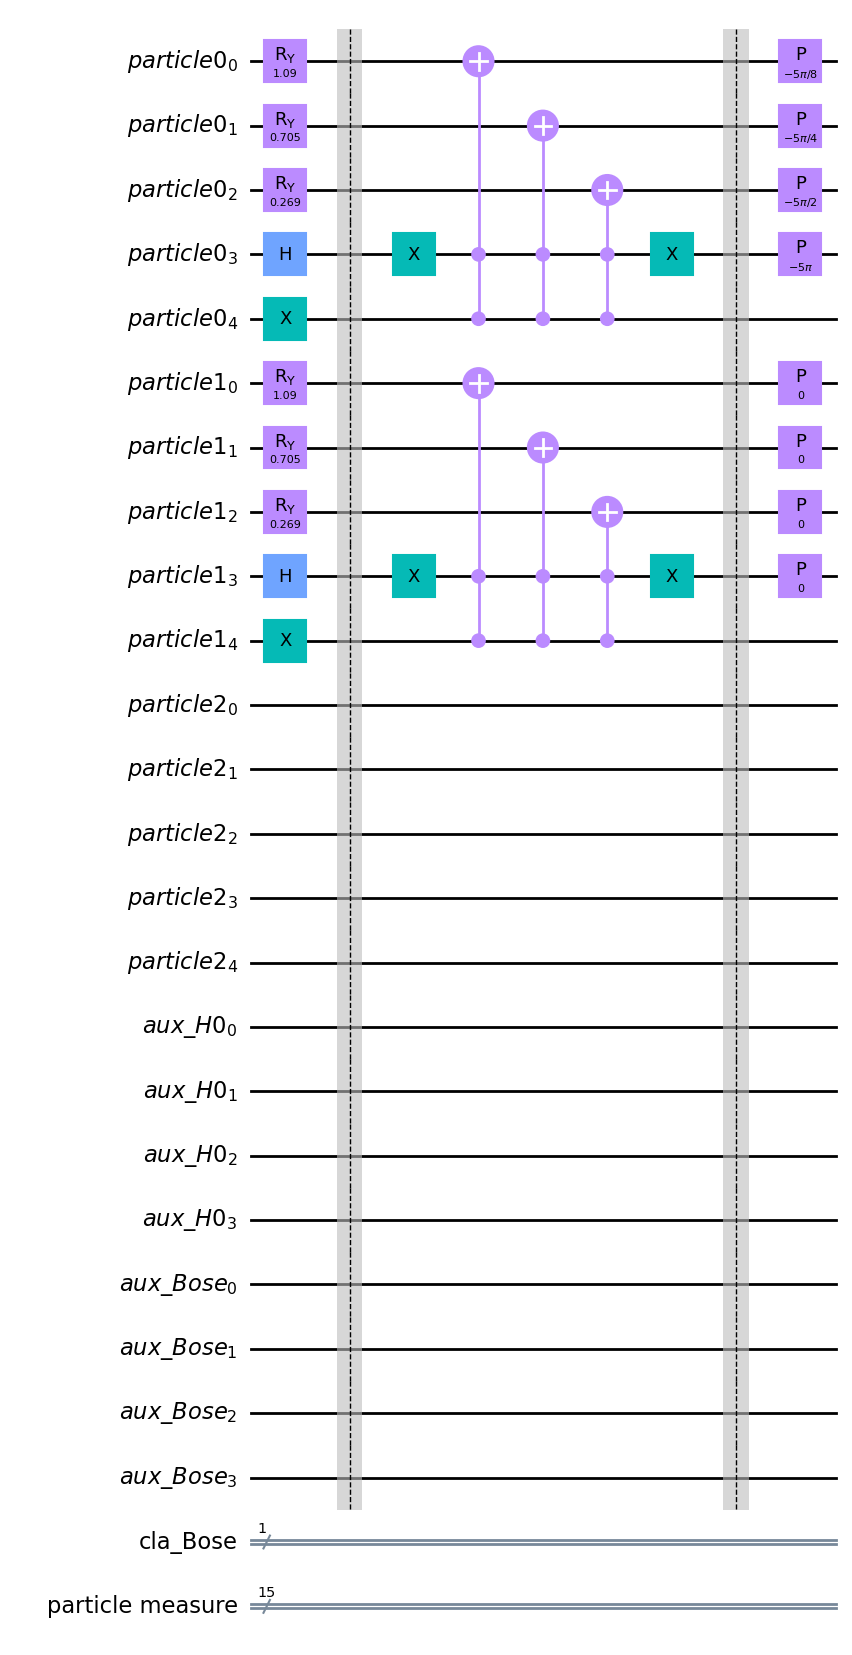

In [232]:
# position translatoin
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
circuit.barrier()

pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 5 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
# pos_trans_mat[1][0] = 4

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

circuit.barrier()

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
        trans_gate.name = f'{ireg}th position {pos_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# you can check wheter wavepackets translate correctly
# qft_gate = qFT(len(particle_regs[0][:N_abs+1]))
# qft_gate.name = 'QFT'
# circuit.append(qft_gate, qargs=particle_regs[0][:N_abs+1])

circuit.decompose().draw('mpl')

In [233]:
# momentum translation
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
circuit.barrier()

for ireg in range(n):
    qft_gate = qFT(particle_regs[ireg].size-1)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

## 波束の運動量空間の重心 pbar を並進移動させる
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 4 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動
# mom_trans_mat[1][0] = -1

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
        trans_gate.name = f'{ireg}th momentum {mom_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# inverse symmetric QFT
for ireg in range(n):
    inv_qft_gate = invQFT(particle_regs[ireg].size-1)
    inv_qft_gate.name = 'inverse QFT'
    circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

# circuit.decompose().draw('mpl')
# circuit.draw('mpl')

In [234]:
# ## Bose symmetrization (M=2, n=1)

# circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(3, N_abs, d)
# # n, Mに応じて改訂する必要あり
# circuit.h(anc_reg_symm[:s])
# for ireg in range(M):
#     for jreg in range(M):
#         for iqubit in range(N):
#             if ireg > jreg:
#                 circuit.cswap(anc_reg_symm[0], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
# # circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# circuit.cx(particle_regs[1][N - 1], anc_reg_symm[:s])

測定された量子ビットの値: 0
Success!
測定された量子ビットの値: 1
Fail...


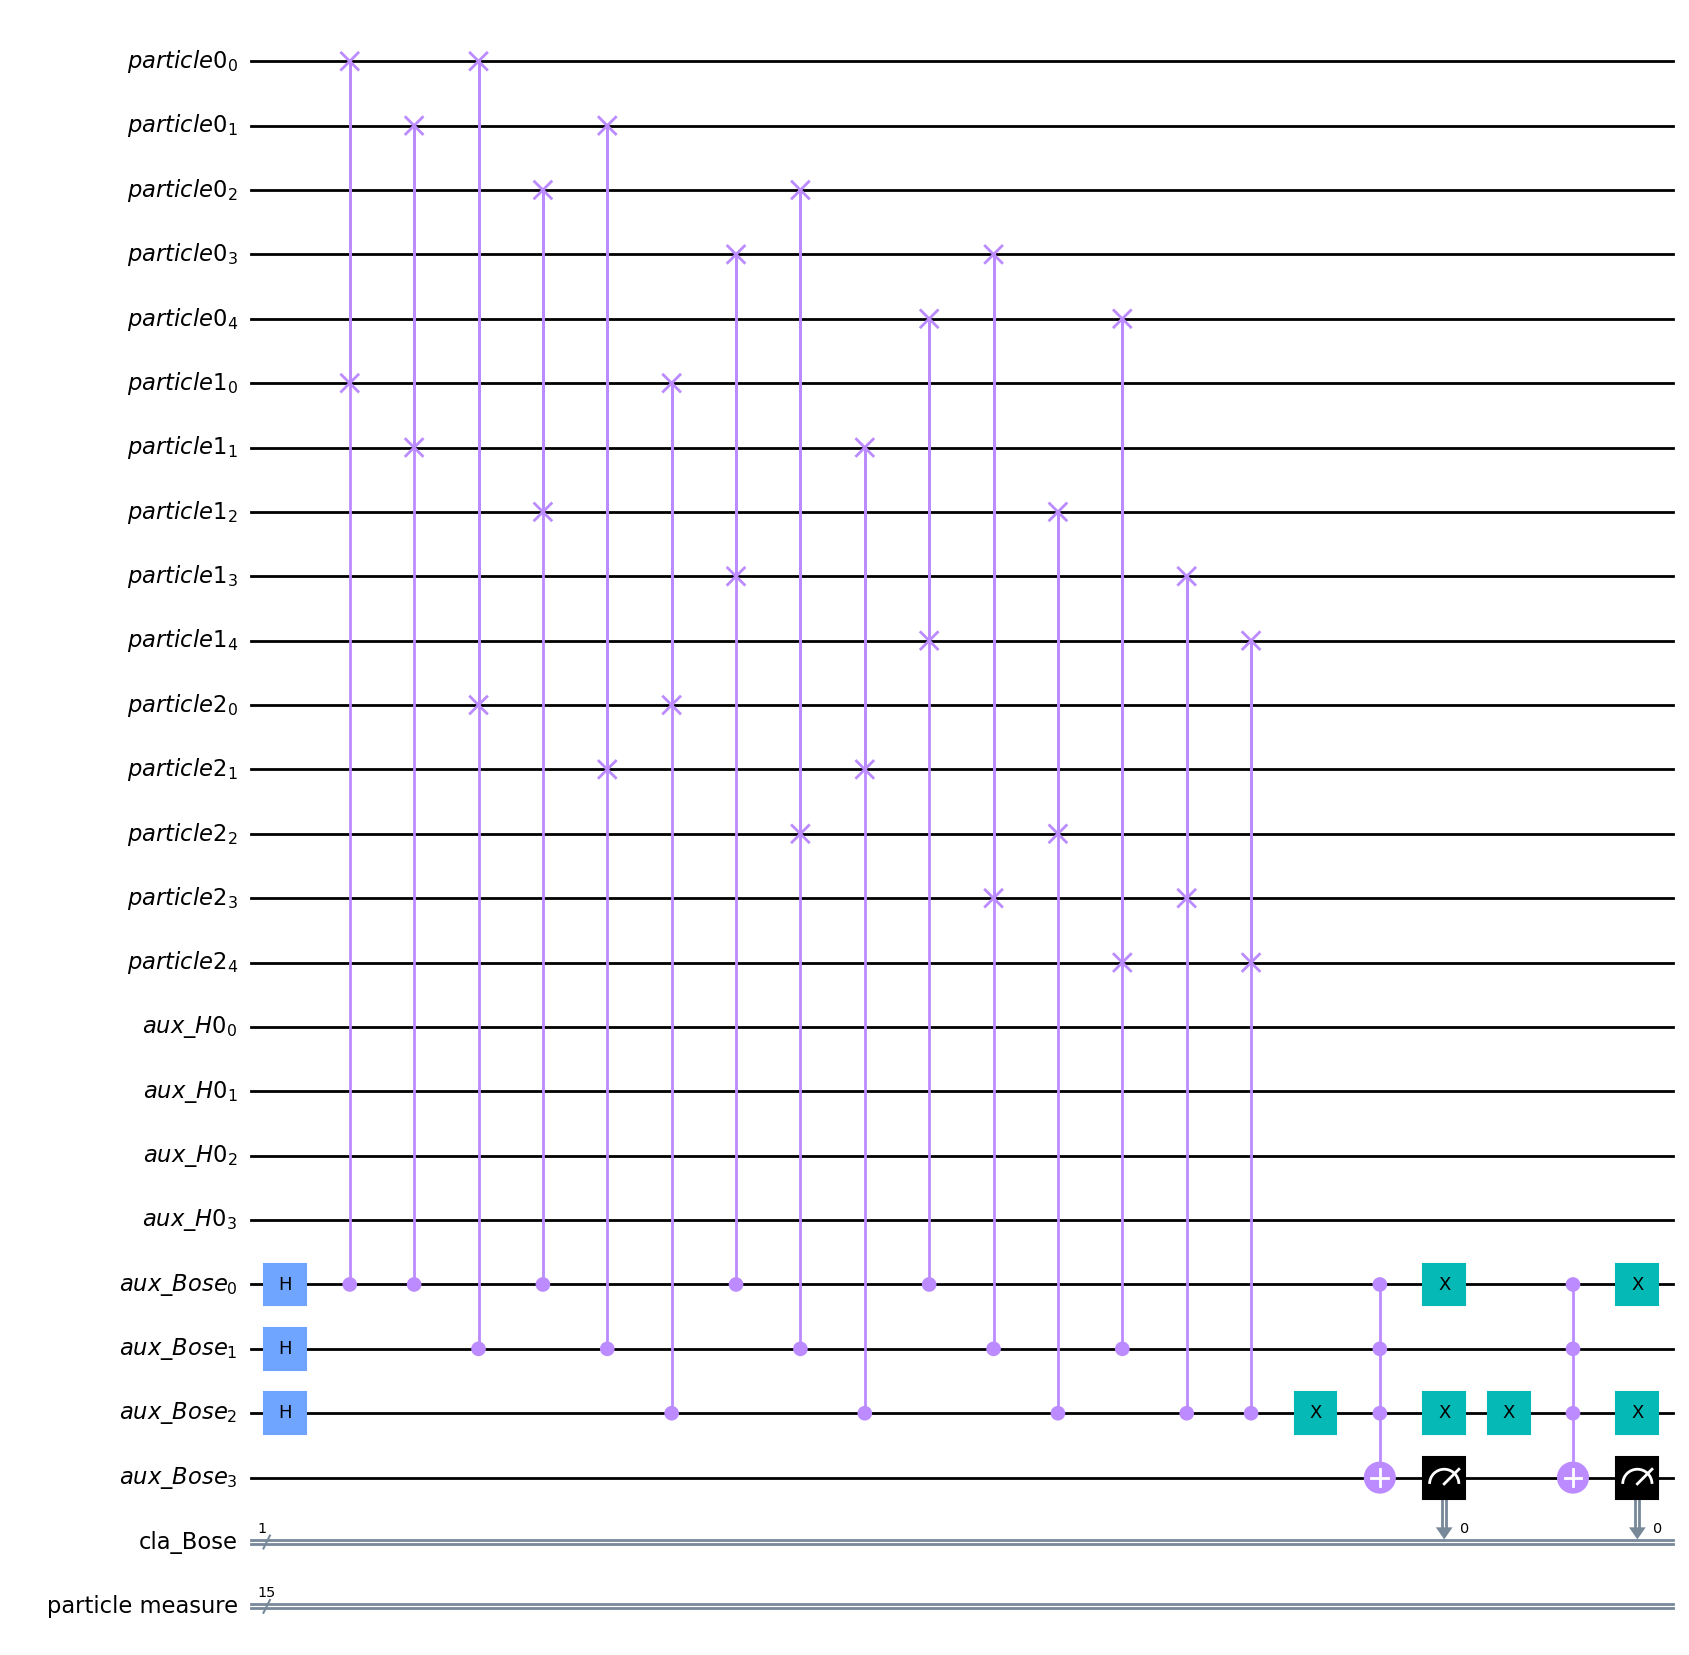

In [235]:
## Bose symmetrization (M=3, n=2)
circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(3, N_abs, d)
# n, Mに応じて改訂する必要あり
circuit.h(anc_reg_symm[:s])
swapnum = 0
for ireg in range(M):
    for jreg in range(M):
        if ireg > jreg:
            for iqubit in range(N):
                circuit.cswap(anc_reg_symm[swapnum], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
            swapnum += 1
        # circuit.barrier()
# circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？

# for |1,1,0>
circuit.x(anc_reg_symm[s-1])
measured_bit = checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm)
circuit.x(anc_reg_symm[s-1])
# for |0,1,0>
circuit.x(anc_reg_symm[0])
circuit.x(anc_reg_symm[s-1])
measured_bit = checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm)
circuit.x(anc_reg_symm[0])
circuit.x(anc_reg_symm[s-1])

circuit.draw('mpl')

Clbit(ClassicalRegister(1, 'cla_Bose'), 0)
Clbit(ClassicalRegister(1, 'cla_Bose'), 0)


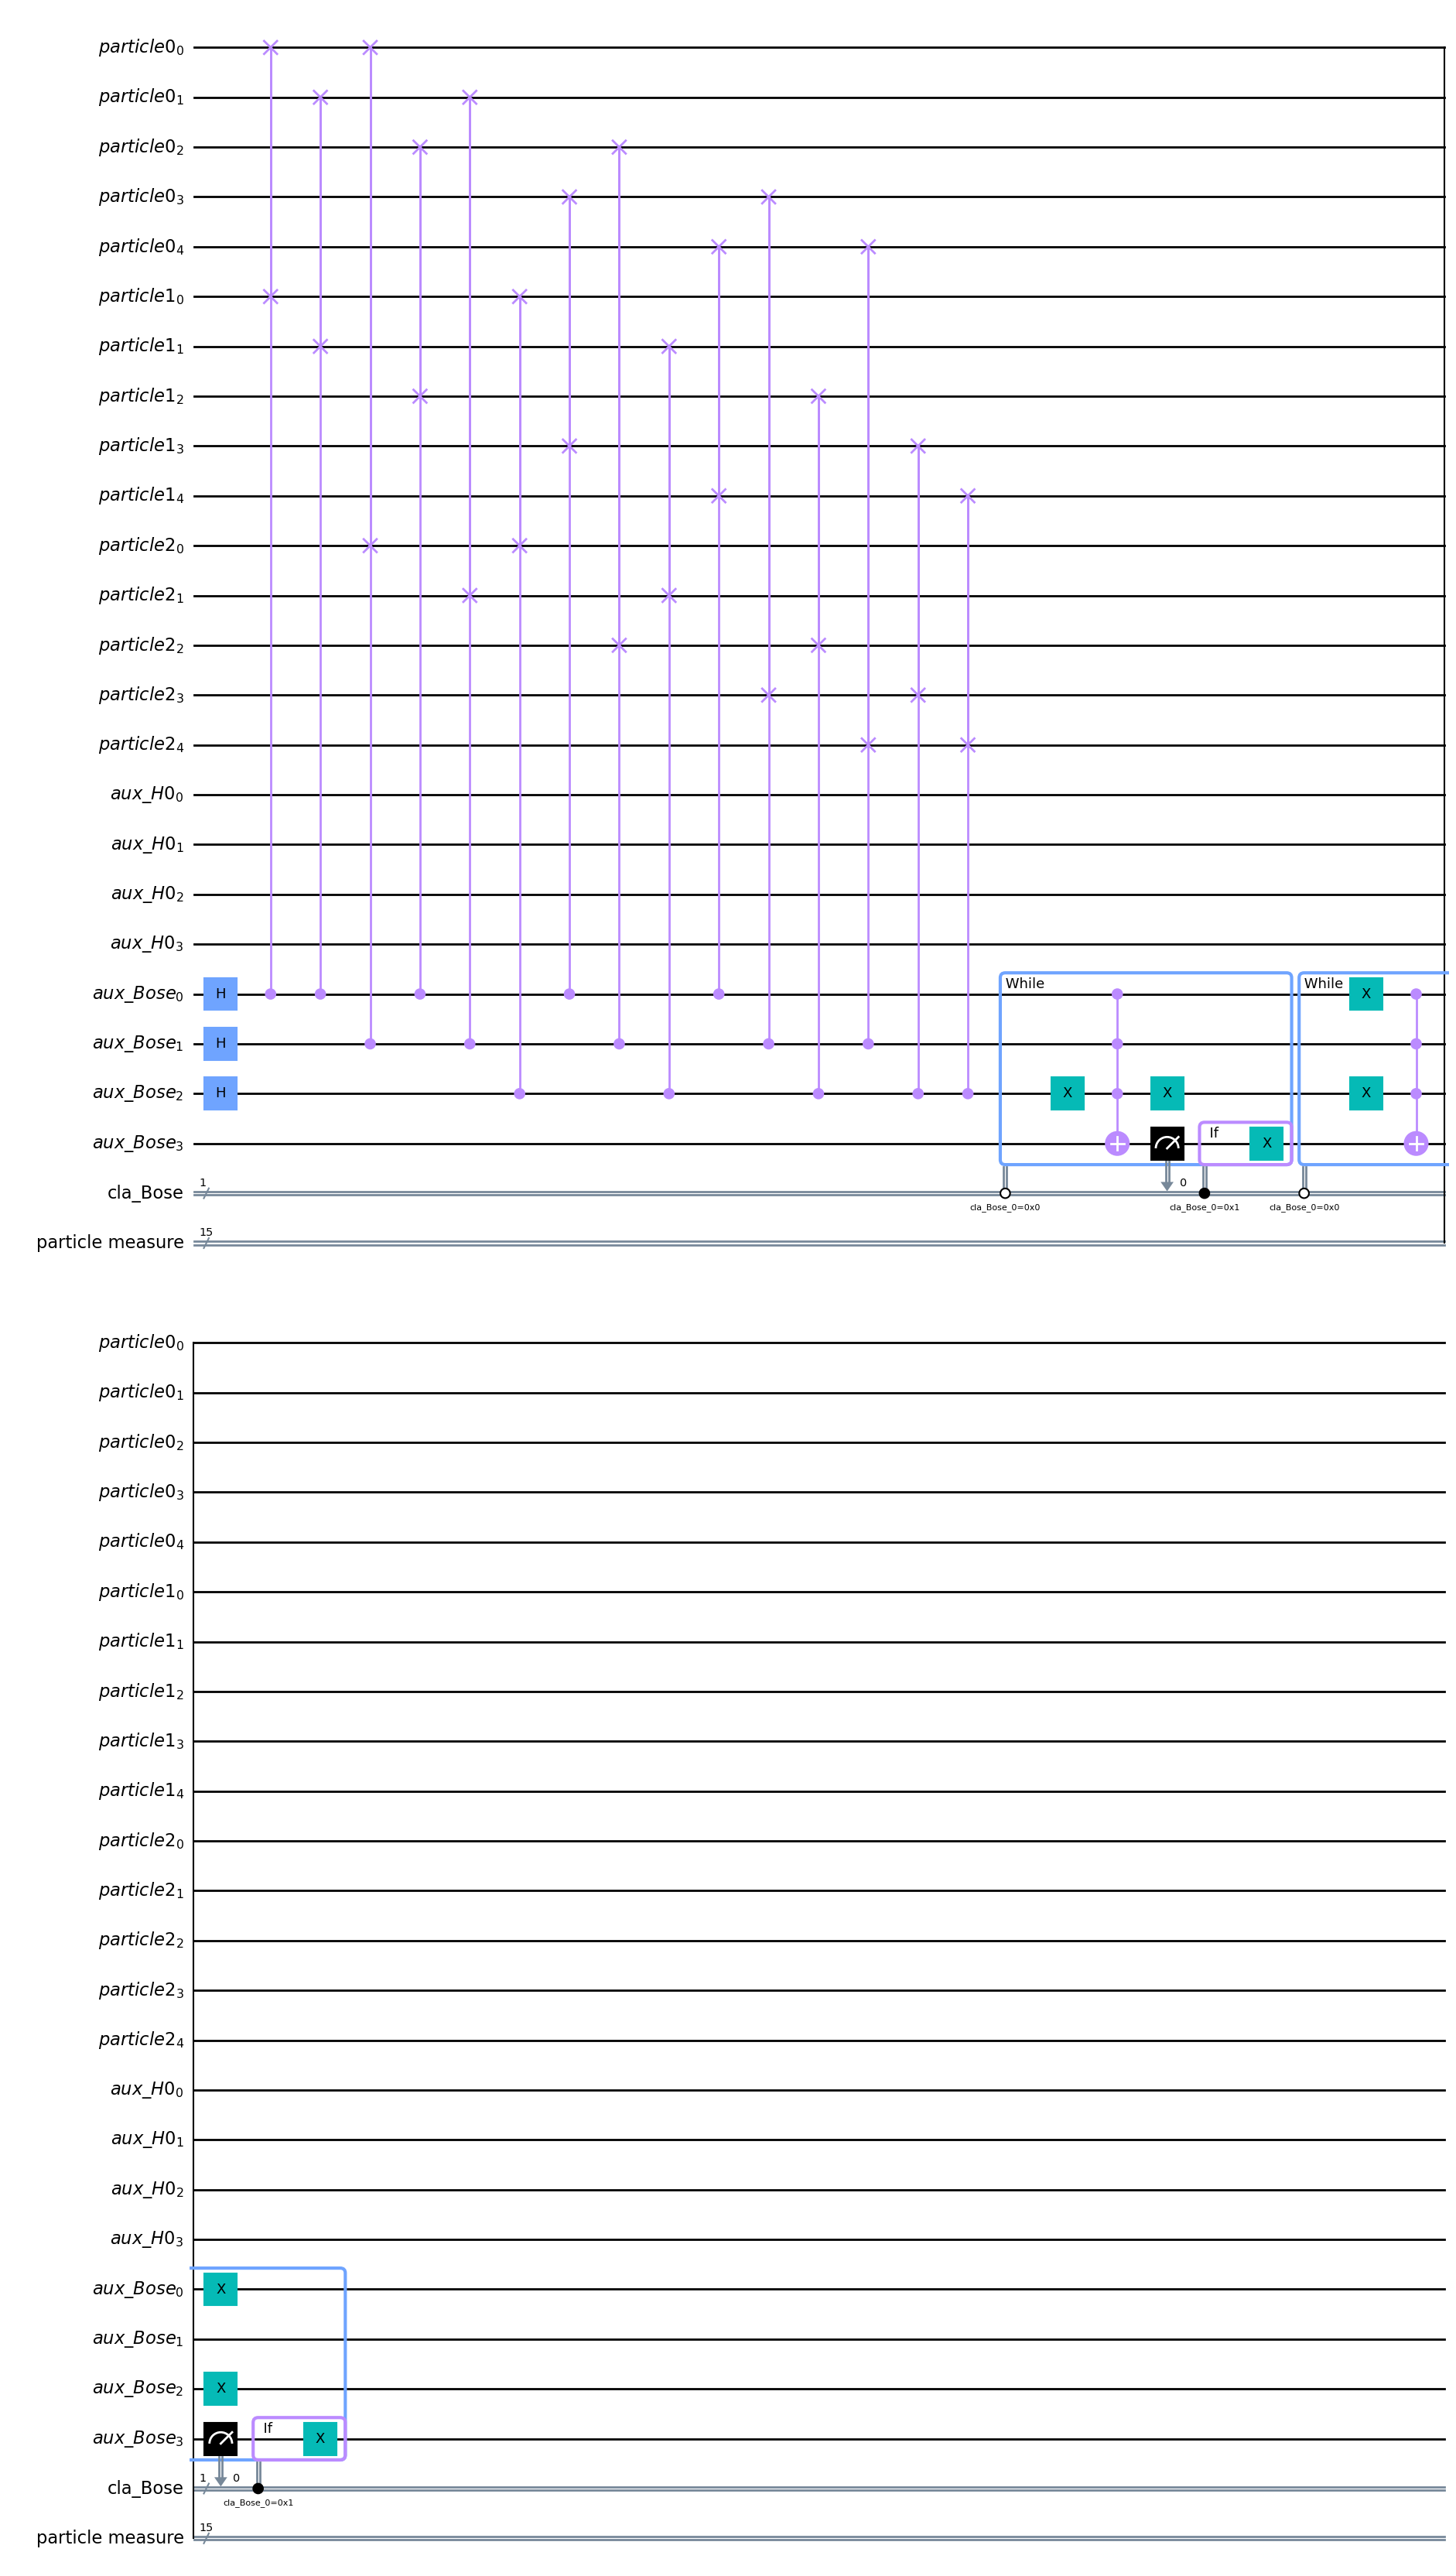

In [236]:
## Bose symmetrization (M=3, n=2)
circuit.barrier()
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(3, N_abs, d)
# n, Mに応じて改訂する必要あり
circuit.h(anc_reg_symm[:s])
swapnum = 0
for ireg in range(M):
    for jreg in range(M):
        if ireg > jreg:
            for iqubit in range(N):
                circuit.cswap(anc_reg_symm[swapnum], particle_regs[ireg][iqubit], particle_regs[jreg][iqubit])
            swapnum += 1
        # circuit.barrier()
# circuit.x(anc_reg_symm[0]) # anc_reg_symm[0]を制御ビットとしてanc_reg_symm[0]を標的ビットにすることはできない？
        
                
with circuit.while_loop((cla_reg_symm[0], False)):
# for |1,1,0>
    circuit.x(anc_reg_symm[s-1])
    # measured_bit = checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm)
    circuit.mcx(anc_reg_symm[:s], anc_reg_symm[s])
    circuit.measure(anc_reg_symm[s], cla_reg_symm[0])
    with circuit.if_test((cla_reg_symm[0], True)):
        circuit.x(anc_reg_symm[s])
        # circuit.measure(particle_1D_list, cla_measure[:])
        print(cla_reg_symm[0])
    circuit.x(anc_reg_symm[s-1])

with circuit.while_loop((cla_reg_symm[0], False)):
    # for |0,1,0>
    circuit.x(anc_reg_symm[0])
    circuit.x(anc_reg_symm[s-1])
    # measured_bit = checkBoseSymm(circuit, anc_reg_symm, cla_reg_symm)
    circuit.mcx(anc_reg_symm[:s], anc_reg_symm[s])
    circuit.measure(anc_reg_symm[s], cla_reg_symm[0])
    # if cla_reg_symm[0] == False:
    print(cla_reg_symm[0])
    with circuit.if_test((cla_reg_symm[0], True)):
        circuit.x(anc_reg_symm[s])
        # circuit.measure(particle_1D_list, cla_measure[:]) # 回路の予約をしているイメージだから、これは動かない
        # simulator = AerSimulator()
        # circuit = transpile(circuit, backend=simulator)
        # job = simulator.run(circuit, shots=100)
        # result = job.result()
        # counts = result.get_counts(circuit)
        # plot_histogram(counts)
    circuit.x(anc_reg_symm[0])
    circuit.x(anc_reg_symm[s-1])

circuit.draw('mpl')

#### A. Initial State Preparation all part ###

In [237]:
M = 3
N = N_abs * d + d + 1
N_abs = 1
d = 1
n = 2

circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
## Gaussian wave packet
for ireg in range(n):
    wave_packet_gate = wavePacket(particle_regs[ireg])
    wave_packet_gate.name = f'{ireg}th wave packet'
    circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

## translatoin parameters
pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 4 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
# pos_trans_mat[1][0] = 4
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 4 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動
# mom_trans_mat[1][0] = -1

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

## translation in position space
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
        trans_gate.name = f'{ireg}th position {pos_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

for ireg in range(n):
    qft_gate = qFT(particle_regs[ireg].size-1)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

## translation in moemntum space
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
        trans_gate.name = f'{ireg}th momentum {mom_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

## inverse symmetric QFT and change representation
for ireg in range(n):
    inv_qft_gate = invQFT(particle_regs[ireg].size-1)
    inv_qft_gate.name = 'inverse QFT'
    circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])
## bose symmetrization (not done)

circuit.draw('mpl')

CircuitError: 'The amount of qubit arguments 3 does not match the instruction expectation (2).'

#### B. Time Evolution ####

In [ ]:
def phiAdditionGate(dphi, particle_regs, anc_reg_h0):
    phi_add_circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    phi_add_circuit.h(anc_reg_h0) # equal superposition
    # addition
    for reg_ctrl in particle_regs:
        for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
            for itarg, qtarg in enumerate(anc_reg_h0):
                phi_add_circuit.cp(dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    phi_add_gate = phi_add_circuit.to_gate()
    return phi_add_gate

def uncomputePhiGate(dphi, particle_regs, anc_reg_h0):
    uncompute_circuit = QuantumCircuit(*particle_regs, anc_reg_h0)
    # addition
    for reg_ctrl in particle_regs:
        for ictrl, qctrl in enumerate(reg_ctrl[0:N_abs * d]):
            for itarg, qtarg in enumerate(anc_reg_h0):
                uncompute_circuit.cp(- dphi * (2 ** (ictrl + itarg)), qctrl, qtarg)
    uncompute_circuit.h(anc_reg_h0) # unsolve equal superposition
    uncompute_gate = uncompute_circuit.to_gate()
    return uncompute_gate

In [ ]:
# |phi>|q1>|q2>...という状態なので, S_phiを構成するゲートを作る（普通のゲートと制御ゲートを作る）
def sPhiGate(anc_reg_h0, M, delta_0):
    s_circuit = QuantumCircuit(anc_reg_h0)
    for ianc, qanc in enumerate(anc_reg_h0):
        phi = -delta_0 / M
        s_circuit.p(phi * (2 ** ianc), qanc)
    s_gate = s_circuit.to_gate()
    cs_gate = s_gate.control(1)
    cs_gate.name = 'Cphi gate'
    return s_gate, cs_gate

In [ ]:
# you can check the motion of wave packets
# time evolution scheme
n = 1
M = 1
N_abs = 3
N = N_abs + 2
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)

delta_t = np.pi/3
pos_trans_mat = np.zeros((n, d))
pos_trans_mat[0][0] = 8 # 第0量子レジスタの第0次元に存在する粒子をhogehogeマス移動
mom_trans_mat = np.zeros((n, d))
mom_trans_mat[0][0] = 0 # 第0量子レジスタの第0次元に存在する粒子の運動量の中心をhogehogeマス移動

## localize wave packets
for ireg in range(n):
    # gauss_gate = preWavePacket(particle_regs[ireg])
    wave_packet_gate = wavePacket(particle_regs[ireg])
    wave_packet_gate.name = f'{ireg}th wave packet'
    circuit.append(wave_packet_gate, qargs=particle_regs[ireg][:])

# circuit.x(particle_regs[0][0])
circuit.x(particle_regs[0][1])
circuit.x(particle_regs[0][2])

## translation in position space
# change basis
circuit.barrier()

for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(pos_trans_mat[ireg][idim], particle_regs[ireg], True)
        trans_gate.name = f'{ireg}th position {pos_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

## translation in momentum space
circuit.barrier()

# QFT
for ireg in range(n):
    qft_gate = qFT(particle_regs[ireg].size-1)
    qft_gate.name = 'QFT'
    circuit.append(qft_gate, qargs=particle_regs[ireg][:N-1])

## translation
for ireg in range(n): # ireg番目の量子レジスタに作用
    for idim in range(d): # idim次元目を考える
        trans_gate = translateGate(mom_trans_mat[ireg][idim], particle_regs[ireg], False)
        trans_gate.name = f'{ireg}th momentum {mom_trans_mat[ireg][idim]} trans'
        circuit.append(trans_gate, qargs=particle_regs[ireg][:])

# inverse symmetric QFT
for ireg in range(n):
    inv_qft_gate = invQFT(particle_regs[ireg].size-1)
    inv_qft_gate.name = 'inverse QFT'
    circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:N-1])

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

## take summation of momenta of all particles
dphi = 2 * np.pi / (2 ** anc_reg_h0.size)
phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
phi_add_gate.name = 'phi addition'
circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])

# inverse QFT
inv_qft_gate = invQFT(len(anc_reg_h0[:]))
inv_qft_gate.name = 'invQFT'
circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

## operate Sphi gate to evolve time
s_gate, cs_gate = sPhiGate(anc_reg_h0, M, delta_t)
s_gate.name = 'Sphi gate'
circuit.append(s_gate, qargs=anc_reg_h0)

## uncompute phi ancilla qubits
# QFT
circuit.barrier()
qft_gate = qFT(len(anc_reg_h0[:]))
qft_gate.name = 'QFT'
circuit.append(qft_gate, qargs=anc_reg_h0[:])
# uncompute
uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
uncompute_gate.name = 'uncompute phi'
circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])

## you can check the motion of the wave packet
# change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])
# QFT
qft_gate = qFT(len(particle_regs[0][:N-1]))
qft_gate.name = 'QFT'
circuit.append(qft_gate, qargs=particle_regs[0][:N-1])

# circuit.draw('mpl')

In [ ]:
#### B. Time Evolution ####
## Free Hamiltonian ##

# circuit.barrier()
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, particle_1D_list = init(M, N_abs, d)
# circuit.x(particle_regs[0][0])
# circuit.x(particle_regs[0][1])
# circuit.x(particle_regs[0][2])
# circuit.x(particle_regs[1][0])
# circuit.x(particle_regs[1][1])
# circuit.x(particle_regs[1][2])

# l0 = anc_reg_h0.size
dphi = 2 * np.pi / (2 ** anc_reg_h0.size)

## change basis
for ireg in range(n):
    basis_change_gate = changeBasis(particle_regs[ireg])
    basis_change_gate.name = 'change basis'
    circuit.append(basis_change_gate, qargs=particle_regs[ireg][:])

phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
phi_add_gate.name = 'phi addition'
circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])
# inverse QFT
inv_qft_gate = invQFT(len(anc_reg_h0[:]))
inv_qft_gate.name = 'invQFT'
circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

# circuit.draw('mpl')

In [ ]:
# evolve time using ancilla qubits
circuit.barrier()
s_gate, cs_gate = sPhiGate(anc_reg_h0, M, 0.5)
s_gate.name = 'Sphi gate'
cs_gate.name = 'Cphi gate'
circuit.append(s_gate, qargs=anc_reg_h0)
for iregs in range(M):
    circuit.x(particle_regs[iregs][N - 1])
    cs_gate.name = 'Sphi gate'
    circuit.append(cs_gate, qargs=([particle_regs[iregs][N - 1]] + anc_reg_h0[:])) # n_omegaの数だけS_phiを作用
    circuit.x(particle_regs[iregs][N - 1])

# uncompute phi ancilla qubits
# QFT
qft_gate = qFT(len(anc_reg_h0[:]))
qft_gate.name = 'QFT'
circuit.append(qft_gate, qargs=anc_reg_h0[:])

uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
uncompute_gate.name = 'uncompute phi'
circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])

# circuit.draw('mpl')

In [ ]:
# 全ての運動量モード、全てのレジスタのパターンに対してSqijを考える
def squeezeGate(qmode, ireg, jreg):
    zq = 0.5 * math.log(qmode + 1/2)
    reg_list = [ireg, jreg]
    sq_circuit = QuantumCircuit(*reg_list)
    modebits = bin(qmode)[2:]

    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 1:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    sq_circuit.cx(jreg[(N_abs + 1) * d], ireg[(N_abs + 1) * d])

    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])
    mcry = RYGate(-2 * zq/M).control(2 * jreg.size - 1)
    sq_circuit.append(mcry, qargs=ireg[:]+jreg[:jreg.size-1] + [jreg[jreg.size-1]])
    # sq_circuit.cry((zq/M), ireg[:]+jreg[:jreg.size-1], jreg[jreg.size-1])
    sq_circuit.x(ireg[:] + jreg[:jreg.size-1])

    sq_circuit.cx(jreg[(N_abs + 1) * d], ireg[(N_abs + 1) * d])
    sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[N_abs])
    for ibit in range(N_abs): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(modebits) > ibit:
            if int(modebits[-(ibit+1)]) == 1:
                sq_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                sq_circuit.cx(jreg[(N_abs + 1) * d], jreg[ibit])

    sq_gate = sq_circuit.to_gate()
    return sq_gate, modebits

In [ ]:
# ## Scheme of squeezing operation
# n = 2
# M = 2
# N_abs = 1
# N = N_abs * d +d + 1
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)

# ireg = particle_regs[0]
# jreg = particle_regs[1]
# sq_gate, modebit = squeezeGate(0, ireg, jreg)
# sq_gate.name = f'mode{0} sq'
# circuit.append(sq_gate, qargs=ireg[:] + jreg[:])
# circuit.barrier()
# # circuit.ry(-2 * zq/M, particle_regs[1][-1])

# circuit.decompose().draw('mpl')

# ## Scheme of squeezing operation
# n = 2
# M = 2
# N_abs = 1
# N = N_abs * d +d + 1
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)

# circuit.cx(particle_regs[1][-1], particle_regs[1][-2])
# circuit.cx(particle_regs[1][-1], particle_regs[0][-1])
# circuit.x(particle_regs[0][:])
# circuit.x(particle_regs[1][:-1])
# mcry = RYGate(-2 * zq/M).control(2 * jreg.size - 1)
# circuit.append(mcry, qargs=ireg[:]+jreg[:jreg.size-1] + [jreg[jreg.size-1]])
# circuit.x(particle_regs[0][:])
# circuit.x(particle_regs[1][:-1])
# circuit.cx(particle_regs[1][-1], particle_regs[0][-1])
# circuit.cx(particle_regs[1][-1], particle_regs[1][-2])

# circuit.barrier()
# circuit.draw('mpl')

In [ ]:
# ## Scheme of squeezing operation
# n = 2
# M = 2
# N_abs = 1
# N = N_abs * d +d
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)

# for imode in range(2 ** N_abs):
#     for inum, ireg in enumerate(particle_regs):
#         for jnum, jreg in enumerate(particle_regs):
#             if inum != jnum:
#                 sq_gate, modebit = squeezeGate(imode, ireg, jreg)
#                 sq_gate.name = f'mode{imode} sq'
#                 circuit.append(sq_gate, qargs=ireg[:] + jreg[:])
#                 circuit.barrier()

# circuit.draw('mpl')

In [ ]:
def intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list, Delta): # done
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg]

    int_circuit = QuantumCircuit(ireg, jreg)
    
    for ihamming in two_hamming_list:
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])
        # mcrx = PhaseGate(Delta * 6).control(2 * ireg.size - 2)
        mcrx = PhaseGate(-Delta).control(2 * ireg.size - 2)
        mcrx.name = 'Phase Gate'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:N-1])
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [ ]:
def intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, Delta): # done
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg]

    int_circuit = QuantumCircuit(ireg, jreg)
    
    for ihamming in two_hamming_list: 
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])
        mcrx = RXGate(2 * Delta).control(2 * ireg.size - 1)
        # mcrx = RXGate(2 * Delta * 8).control(2 * ireg.size - 1)
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:])
        int_circuit.x(ireg[:N] + jreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 1:
                int_circuit.cx(jreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [ ]:
def intHamiltonianFourIndices(ireg, ipos, Delta): # done
    pos_bits = bin(ipos)[2:]

    int_circuit = QuantumCircuit(ireg)

    for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    int_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
                    
    int_circuit.x(ireg[:N_abs + d])
    mcrx = PhaseGate(-Delta).control(ireg.size - 2)
    mcrx.name = 'Phase Gate'
    int_circuit.append(mcrx, qargs=ireg[:N-1])
    # int_circuit.cp(Delta, ireg[:N_abs+d], ireg[N_abs+d])
    int_circuit.x(ireg[:N_abs + d])

    pos_bits = bin(ipos)[2:]
    for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
        if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    int_circuit.cx(ireg[(N_abs + 1) * d], ireg[ibit])
    
    int_gate = int_circuit.to_gate()

    return int_gate

In [ ]:
def intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, Delta): # done
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg, kreg] # ireg corresponds to sigma^2

    int_circuit = QuantumCircuit(ireg, jreg, kreg)

    for ihamming in three_hamming_list:
        # int_circuit.barrier()
        for istring in range(len(ihamming)): # add X gate
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            if ihamming[istring] == '1':
                                int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
        # int_circuit.barrier()

        for ibit in range(N_abs * d + d): # flip qubits to make |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xnum, xreg in enumerate(reg_list):
                        if xnum > 0:
                            int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        # int_circuit.barrier()

        for xnum, xreg in enumerate(reg_list):
            if xnum != 2 and xnum != 0:
                int_circuit.cx(kreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        # int_circuit.barrier()
        
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N_abs + d])
        # mcrx = RXGate(2 * Delta * 12).control(3 * ireg.size - 1)
        mcrx = RXGate(Delta).control(3 * ireg.size - 1) # 2倍いらない？なぜ？
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:] + kreg[:])
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N_abs + d])
        # int_circuit.barrier()

        for xnum, xreg in enumerate(reg_list):
            if xnum != 2 and xnum != 0:
                int_circuit.cx(kreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        # int_circuit.barrier()

        for ibit in range(N_abs * d + d): # flip qubits to make |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xnum, xreg in enumerate(reg_list):
                        if xnum > 0:
                            int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        # int_circuit.barrier()

        for istring in range(len(ihamming)): # add X gate
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            if ihamming[istring] == '1':
                                int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

    int_gate = int_circuit.to_gate()

    return int_gate

In [ ]:
def interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list, Delta):
    pos_bits = bin(ipos)[2:]
    reg_list = [ireg, jreg, kreg, lreg]

    int_circuit = QuantumCircuit(ireg, jreg, kreg, lreg)

    for ihamming in hamming_list:
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])

        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        for xnum, xreg in enumerate(reg_list):
            if xnum != 3:
                int_circuit.cx(lreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N] + lreg[:N_abs + d])
        mcrx = RXGate(2 * Delta).control(4 * ireg.size - 1)
        # mcrx = RXGate(2 * Delta * 24).control(4 * ireg.size - 1) # 24 corresponds the permutation of registers 4! = 24
        mcrx.name = 'MultiCNOT'
        int_circuit.append(mcrx, qargs=ireg[:] + jreg[:] + kreg[:] + lreg[:jreg.size-1] + [lreg[lreg.size-1]])
        int_circuit.x(ireg[:N] + jreg[:N] + kreg[:N] + lreg[:N_abs + d])

        for xnum, xreg in enumerate(reg_list):
            if xnum != 3:
                int_circuit.cx(lreg[(N_abs + 1) * d], xreg[[(N_abs + 1) * d]])
        for ibit in range(N_abs * d + d): # flip qubits to make |qi>|-qj> <=> |11...1>
            if len(pos_bits) > ibit:
                if int(pos_bits[-(ibit+1)]) == 1:
                    for xreg in reg_list:
                        int_circuit.cx(xreg[(N_abs + 1) * d], xreg[ibit])
        
        for istring in range(len(ihamming)): # add X gate
            if ihamming[istring] == '1':
                for ibit in range(N_abs * d + d):
                    if len(pos_bits) > ibit:
                        if int(pos_bits[-(ibit+1)]) == 1:
                            int_circuit.x(reg_list[istring][ibit])
                if ihamming[istring] == '1':
                    int_circuit.x(reg_list[istring][N-1])
    
    int_gate = int_circuit.to_gate()

    return int_gate

/Users/maeno0ta/single-particle-qft/.venv/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


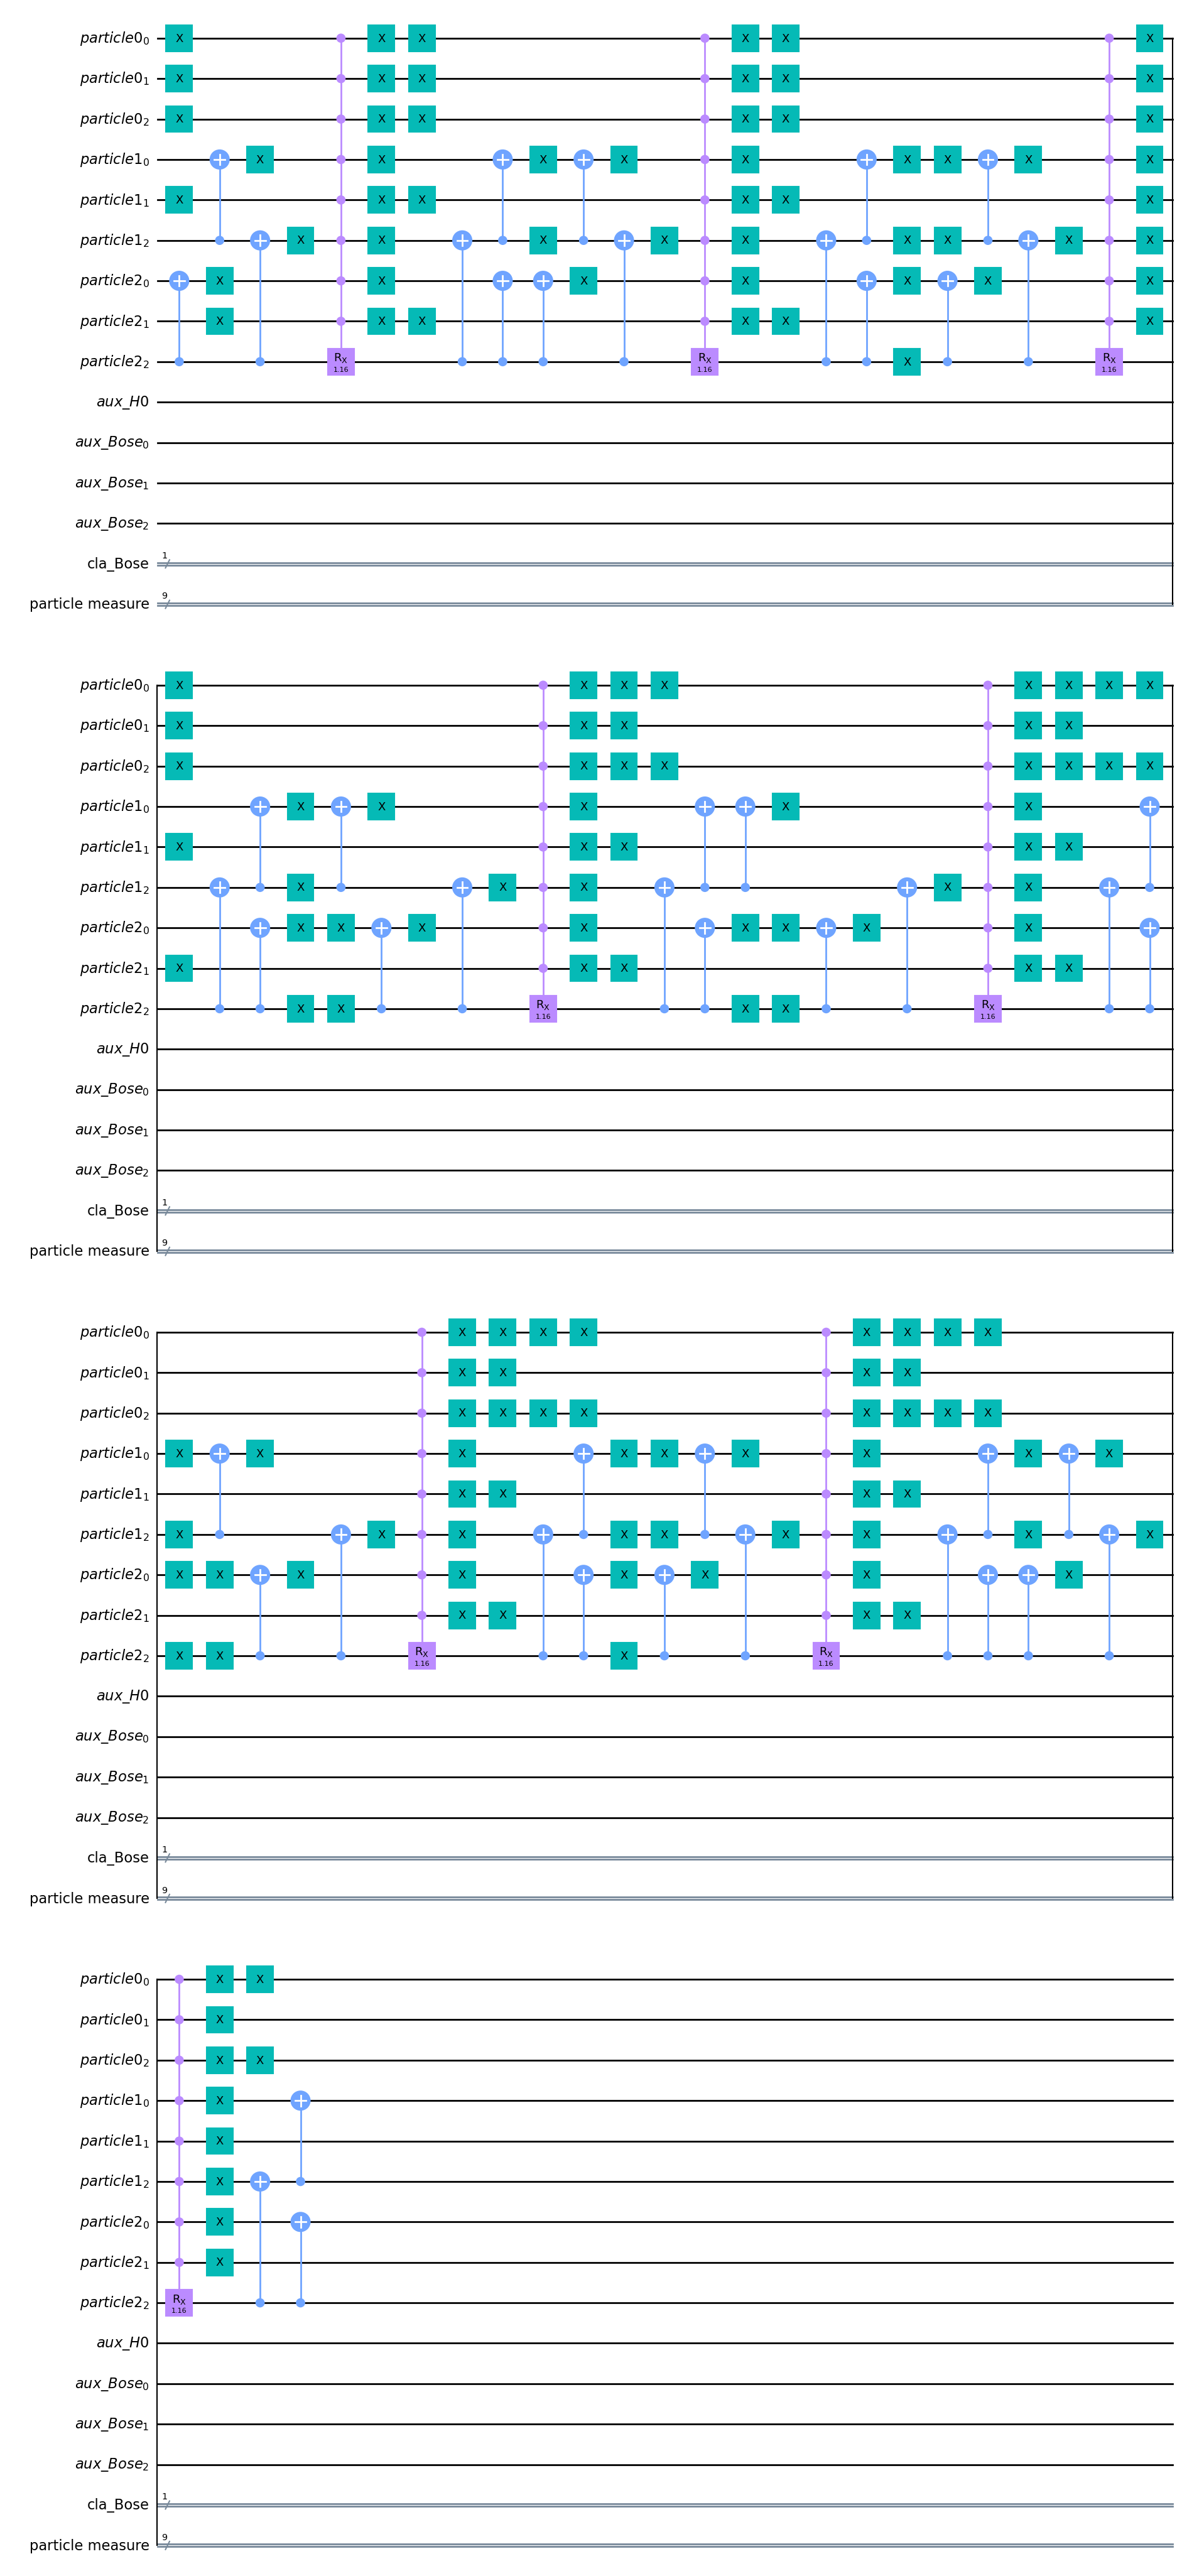

In [265]:
M = 3
N_abs = 1
d = 1
N = N_abs * d + d + 1
n = 1

circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
ipos = 1
ireg = particle_regs[0]
jreg = particle_regs[1]
kreg = particle_regs[2]
# lreg = particle_regs[3]
two_hamming_list = ['00', '10']
three_hamming_list = ['000', '010', '011', '001', '101', '111', '110', '100'] # ith register corresponds to invariant register
hamming_list = ['1000', '1100', '0100', '0110', '0010', '0000', '0001', '0101'] # 0 corresponds to vacuum state |Omega>^(i), 1 corresponds to |n>^(i)
# three_hamming_list = ['000']
delta = 1
coupling_lambda = 1000
Delta = (delta * coupling_lambda) / (96 * (M ** 2))

# circuit.x(particle_regs[0][0])
# circuit.x(particle_regs[0][1])
# intHamiltonianTwoIndices(circuit, ireg, jreg, kreg, ipos, three_hamming_list)
# int_gate = intHamiltonianFourIndices(ireg, ipos, -Delta)
# int_gate = intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list, Delta)
int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, Delta)
# int_gate = intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, Delta)
# int_gate = interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list, Delta)
int_gate.name = f'pos{ipos} intH'
circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:])
# circuit.append(int_gate, qargs=particle_1D_list)

circuit.decompose().draw('mpl')

In [266]:
# Show the state vector
simulator = AerSimulator(method='statevector')
circuit.save_statevector()
circuit = transpile(circuit, backend=simulator)
statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])
print(statevector)

list = []
eps = 0.01
for i in range(len(statevector)):
    if np.abs(statevector[i]) > eps:
        list.append(statevector[i])
        print(i)
list

[ 4.01715082e-01-4.33917511e-15j  2.45979544e-17-2.53806686e-31j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  2.05979376e-16-3.04355011e-16j  8.57860636e-33+6.44534835e-34j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -2.99756231e-16+1.40184707e-15j  3.93782162e-33+6.36499438e-32j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  2.48385801e-16-4.06478390e-16j  2.09955379e-32-3.61961686e-32j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  4.16333634e-17+7.48513402e-16j  5.26042891e-33+9.70123971e-33j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -1.56827074e-31+1.60326474e-31j  1.19696579e-48-1.28583766e-49j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -2.07364352e-30-3.17289955e-31j -3.38988382e-47+2.08048448e-48j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  6.02184443e-32-7.59966804e-32j  1.11450019e-48+1.45737002e-47j
  0.00000000e+00+0.000000

[(0.4017150816053818-4.339175112166567e-15j),
 (-8.801403218010803e-15-0.9157647040647511j)]

### B. Time evolution all part ###

In [257]:
M = 3
N_abs = 1
d = 1
N = N_abs * d + d + 1
n = 1

tau_0 = 1 # Wigner delay
tau_I = 0 # length of time of interaction
delta = 1.5 # time step
circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
m_0 = 0.5 # chosen to represent a relevant enrgy scale in the weak coupling regime
hamming_list = ['1000', '1100', '0100', '0110', '0010', '0000', '0001', '0101']
two_hamming_list = ['00', '10']
three_hamming_list = ['000', '010', '011', '001', '101', '111', '110', '100'] # ith register corresponds to invariant register
# three_hamming_list = ['000']

tau = 0
m_t = m_0
lambda_t = 1

m_ren = 0
lambda_ren = 1

while tau <= tau_0 + tau_I:
    print(lambda_t)
    Delta = (20 * delta * lambda_t) / (96 * (M ** 2))
    # ## take summation of momenta of all particles
    # dphi = 2 * np.pi / (2 ** anc_reg_h0.size)
    # phi_add_gate = phiAdditionGate(dphi, particle_regs, anc_reg_h0)
    # phi_add_gate.name = 'phi addition'
    # circuit.append(phi_add_gate, qargs=particle_1D_list + anc_reg_h0[:])

    # # inverse QFT
    # inv_qft_gate = invQFT(len(anc_reg_h0[:]))
    # inv_qft_gate.name = 'invQFT'
    # circuit.append(inv_qft_gate, qargs=anc_reg_h0[:])

    # ## operate Sphi gate to evolve time
    # s_gate, cs_gate = sPhiGate(anc_reg_h0, M, delta)
    # s_gate.name = 'Sphi gate'
    # circuit.append(s_gate, qargs=anc_reg_h0)

    # ## uncompute phi ancilla qubits
    # # QFT
    # # circuit.barrier()
    # qft_gate = qFT(len(anc_reg_h0[:]))
    # qft_gate.name = 'QFT'
    # circuit.append(qft_gate, qargs=anc_reg_h0[:])
    # # uncompute
    # uncompute_gate = uncomputePhiGate(dphi, particle_regs, anc_reg_h0)
    # uncompute_gate.name = 'uncompute phi'
    # circuit.append(uncompute_gate, qargs=particle_1D_list + anc_reg_h0[:])
    # circuit.barrier()

    # for imode in range(2 ** N_abs):
    #     for inum, ireg in enumerate(particle_regs):
    #         for jnum, jreg in enumerate(particle_regs):
    #             if inum != jnum:
    #                 sq_gate, modebit = squeezeGate(imode, ireg, jreg)
    #                 sq_gate.name = f'mode{imode+(1/2)} sq'
    #                 circuit.append(sq_gate, qargs=ireg[:] + jreg[:])

    # circuit.barrier()

    # # symmetric QFT
    # for ireg in range(M):
    #     change_gate = changeBasis(particle_regs[ireg])
    #     change_gate.name = 'change basis'
    #     circuit.append(change_gate, qargs=particle_regs[ireg][:])
    #     qft_gate =qFT(particle_regs[ireg].size-1)
    #     qft_gate.name = 'QFT'
    #     circuit.append(qft_gate, qargs=particle_regs[ireg][:-1])

    # circuit.barrier()

    # interaction part
    for ipos in range(2 ** (N_abs * d + d)):
    #     dummy = 0
    # ipos = 1
    # if ipos == 1:
        # 4 indices match
        for inum, ireg in enumerate(particle_regs):
            # print('inum', inum)
            int_gate = intHamiltonianFourIndices(ireg, ipos, Delta)
            int_gate.name = f'pos{ipos} intH4'
            circuit.append(int_gate, qargs=ireg[:])

        # 3 indices match
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                if inum < jnum:
                    # print('inum, junm', inum, jnum)
                    int_gate = intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, 8 * Delta)
                    # int_gate = intHamiltonianThreeIndices(ireg, jreg, ipos, two_hamming_list, Delta)
                    int_gate.name = f'pos{ipos} intH3'
                    circuit.append(int_gate, qargs=ireg[:]+jreg[:])

        # 2 indices match
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                for knum, kreg in enumerate(particle_regs):
                    if inum != jnum and inum != knum and jnum < knum:
                        # print('inum, junm, knum', inum, jnum, knum)
                        int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, 12 * Delta)
                        # int_gate = intHamiltonianTwoIndices(ireg, jreg, kreg, ipos, three_hamming_list, Delta)
                        int_gate.name = f'pos{ipos} intH2'
                        circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:])

        # 2 pairs of indices match
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                if inum < jnum:
                    # print('inum, junm', inum, jnum)
                    int_gate = intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list, Delta * 6)
                    # int_gate = intHamiltonianTwoPairs(ireg, jreg, ipos, two_hamming_list, Delta)
                    int_gate.name = f'pos{ipos} intH22'
                    circuit.append(int_gate, qargs=ireg[:]+jreg[:])

        # all differ
        for inum, ireg in enumerate(particle_regs):
            for jnum, jreg in enumerate(particle_regs):
                for knum, kreg in enumerate(particle_regs):
                    for lnum, lreg in enumerate(particle_regs):
                        if inum < jnum and jnum < knum and knum < lnum:
                            # print('inum, junm, knum, lnum', inum, jnum, knum, lnum)
                            int_gate = interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list, 24 * Delta)
                            # int_gate = interactionHamiltonianAllDiffer(ireg, jreg, kreg, lreg, ipos, hamming_list, Delta)
                            int_gate.name = f'pos{ipos} intH'
                            circuit.append(int_gate, qargs=ireg[:]+jreg[:]+kreg[:]+lreg[:])

    # circuit.barrier()

    # # symmetric QFT
    # for ireg in range(M):
    #     inv_qft_gate =invQFT(particle_regs[ireg].size-1)
    #     inv_qft_gate.name = 'invQFT'
    #     circuit.append(inv_qft_gate, qargs=particle_regs[ireg][:-1])
    #     change_gate = changeBasis(particle_regs[ireg])
    #     change_gate.name = 'change basis'
    #     circuit.append(change_gate, qargs=particle_regs[ireg][:])

    tau += delta
    if tau < tau_0: # turn on interaction adiabatically
        lambda_t = lambda_ren * (tau / tau_0)
        m_t = m_0 * (1 - (tau / tau_0)) + m_ren * (tau / tau_0)
    elif tau_0 <= tau : # interaction completely
        m_t = m_ren
        lambda_t = lambda_ren
    circuit.barrier()

# circuit.decompose().draw('mpl')

1


In [258]:
# circuit, particle_regs, anc_reg_h0, anc_reg_symm, cla_reg_symm, cla_measure, particle_1D_list = init(M, N_abs, d)
# circuit.decompose().draw('mpl')

In [259]:
## Show the state vector
simulator = AerSimulator(method='statevector')
circuit.save_statevector()
circuit = transpile(circuit, backend=simulator)
statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])
print(statevector)

[ 5.13496494e-02-5.51780226e-02j  3.64145112e-15+3.25706006e-15j
  8.16830434e-16+7.49991270e-16j  6.73421483e-17+4.22406833e-17j
  1.29746249e-15+1.17861868e-15j  2.95158546e-16+1.59110552e-15j
  4.90261181e-16+2.49341690e-16j -1.30315431e-16+4.71067883e-16j
  2.56165581e-15-2.28586929e-16j -2.34590672e-16-7.47708860e-15j
  9.98079362e-20-2.43560002e-18j  6.26004055e-18+2.12941617e-18j
  2.12755008e-16-2.74536541e-15j  3.55439153e-16-3.69529718e-16j
 -1.29315647e-16-1.79180368e-16j -1.12185774e-17-7.19753723e-18j
  2.16985402e-16+6.56445178e-16j -3.15764866e-18+3.73368542e-18j
 -7.61850796e-17-4.91302018e-15j  5.34692376e-18-1.06916383e-17j
 -2.21468898e-16-4.55134945e-16j -2.49913232e-16-1.68303412e-16j
 -1.92528362e-17-7.27247024e-17j  3.15952651e-17+3.99403872e-16j
 -7.76586405e-18-3.31964672e-18j -4.23850307e-18+2.44655893e-18j
  2.41101649e-17-1.02527606e-17j -1.38953842e-16-9.00305926e-15j
 -4.36244975e-16-1.13696888e-15j -2.57748021e-16-5.86098384e-16j
 -1.55915082e-16+9.290001

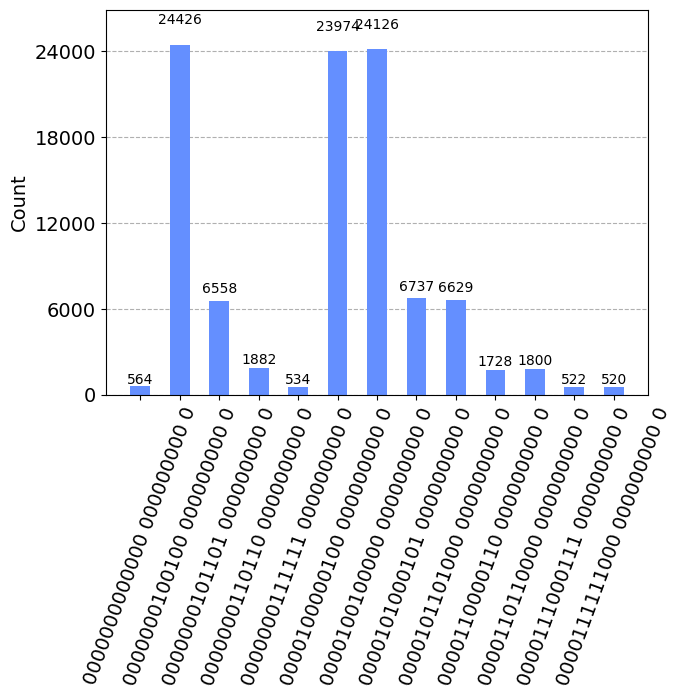

In [261]:
## how to measure and count
circuit.measure_all()
# Run the circuit in qasm_simulator and plot the histogram
simulator = AerSimulator()
circuit = transpile(circuit, backend=simulator)
job = simulator.run(circuit, shots=100000)
result = job.result()
counts = result.get_counts(circuit)
plot_histogram(counts)

# plot y axis logarithmically
# log_data = {key: np.log10(value + 1) for key, value in counts.items()}
# # プロット
# plot_histogram(log_data, bar_labels=False)

In [260]:
# # Show the state vector
# simulator = AerSimulator(method='statevector')
# circuit.save_statevector()
# circuit = transpile(circuit, backend=simulator)
# statevector = np.asarray(simulator.run(circuit).result().data()['statevector'])

# 計算結果を含んだファイルをインポート
# %run 'matrix_cal.ipynb'
result_file = 'calculated_result.pkl'

# 計算結果を読み込む
with open(result_file, 'rb') as f:
    loaded_result_state = pickle.load(f)

# 計算結果を使って何かを行う
ket_state = loaded_result_state
# print(result_state)
# print(result_state)

# print(np.linalg.norm(statevector - result_state))
bra_state = np.conjugate(statevector.T)
print(np.abs(np.dot(bra_state, ket_state)))

0.3933416400792819
